In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

### Cargo el dataset y proporciono los tipos de datos cada columna.

In [2]:

# Leer el archivo, asumiendo que está separado por espacios
# Leer el archivo en formato de ancho fijo
df = pd.read_fwf('registro_temperatura365d_smn.txt',
                encoding='latin1',
                skiprows=[1])

# Eliminar filas donde 'NOMBRE' sea igual a los guiones
df = df[df['NOMBRE'] != '----------------------------------------']

# Convertir la columna FECHA a tipo datetime.
# En el dataset, la fecha está en formato DDMMYYYY, por ejemplo, "26032025" es 26/03/2025.
df['FECHA'] = pd.to_datetime(df['FECHA'], format='%d%m%Y', errors='coerce')

# Convertir TMAX y TMIN a números (float), forzando la conversión y convirtiendo en NaN los que no se puedan convertir.
df['TMAX'] = pd.to_numeric(df['TMAX'], errors='coerce')
df['TMIN'] = pd.to_numeric(df['TMIN'], errors='coerce')

# Convertir NOMBRE a string, aunque generalmente ya se interpreta como tal.
df['NOMBRE'] = df['NOMBRE'].astype(str)
print(f"Cantidad de estaciones únicas: {df['NOMBRE'].nunique()}")
#print(sorted(df['NOMBRE'].unique()))





Cantidad de estaciones únicas: 118


In [3]:
# Verificación: mostrar la información del dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 42915 entries, 1 to 42915
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   FECHA   42915 non-null  datetime64[ns]
 1   TMAX    38377 non-null  float64       
 2   TMIN    42294 non-null  float64       
 3   NOMBRE  42915 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 1.6+ MB
None


### Ver el resumen de datos faltantes

In [4]:
# Me proporciona la cantidad de nulos (NaN) por columna.
df.isna().sum()

FECHA        0
TMAX      4538
TMIN       621
NOMBRE       0
dtype: int64

### Localizar las estaciones con valores faltantes en TMAX.

In [5]:
# Filtramos las filas donde TMAX es nulo
df_missing = df[df['TMAX'].isna()]

# Agrupamos por estación y contamos cuántos faltantes
missing_counts = df_missing.groupby('NOMBRE').size().reset_index(name='count_missing')

# Mostramos de mayor a menor
missing_counts = missing_counts.sort_values('count_missing', ascending=False)

print(missing_counts)


                              NOMBRE  count_missing
5                      CHAMICAL AERO            365
28                   RIO CUARTO AERO            365
11  ESCUELA DE AVIACION MILITAR AERO            365
9                       DOLORES AERO            351
29            SAN ANTONIO OESTE AERO            347
17               MARIANO MORENO AERO            339
38                       VIEDMA AERO            327
32                     TARTAGAL AERO            322
19              MENDOZA OBSERVATORIO            302
4                         CERES AERO            273
31        SANTA ROSA DE CONLARA AERO            177
22                MONTE CASEROS AERO            175
35                      USHUAIA AERO            137
24                       PARANA AERO            116
20                        MERLO AERO             96
26                PERITO MORENO AERO             84
18                      MENDOZA AERO             84
0                  BAHIA BLANCA AERO             74
23          

 ### Opcional: Ver cuántos datos totales distinto de valores faltantes reporta cada estación

In [6]:
total_by_station = df.groupby('NOMBRE').size().reset_index(name='count_total')
total_by_station.sort_values('count_total', ascending=False, inplace=True)

print(total_by_station)


                 NOMBRE  count_total
0       AEROPARQUE AERO          365
74         POSADAS AERO          365
86         ROSARIO AERO          365
85            RIVADAVIA          365
84      RIO GRANDE B.A.          365
..                  ...          ...
14   CAMPO DE MAYO AERO          362
64                OBERA          341
40               JACHAL          340
112           VICTORICA          326
20       CHILECITO AERO          301

[118 rows x 2 columns]


In [7]:

# Supongamos que ya cargaste el dataframe 'df'
# Por ejemplo:
# df = pd.read_csv('registro_temperatura365d_smn.txt', delim_whitespace=True, names=['FECHA', 'TMAX', 'TMIN', 'NOMBRE'], header=0)

# 1. Calcular el número total de registros por estación
total_por_estacion = df.groupby('NOMBRE').size().reset_index(name='total_registros')

# 2. Calcular el número de registros con TMAX faltante por estación
faltantes_por_estacion = df[df['TMAX'].isna()].groupby('NOMBRE').size().reset_index(name='cantidad_valores_faltantes')

# 3. Unir ambos resultados (se usa 'left' para incluir todas las estaciones)
estaciones_faltantes = pd.merge(total_por_estacion, faltantes_por_estacion, on='NOMBRE', how='left')
estaciones_faltantes['cantidad_valores_faltantes'] = estaciones_faltantes['cantidad_valores_faltantes'].fillna(0)  # Reemplazar NaN por 0

# 4. Calcular el porcentaje de datos faltantes
estaciones_faltantes['porc_faltantes'] = (estaciones_faltantes['cantidad_valores_faltantes'] / estaciones_faltantes['total_registros']) * 100

# 5. Ordenar el resultado de mayor a menor porcentaje de faltantes
estaciones_faltantes = estaciones_faltantes.sort_values('porc_faltantes', ascending=False)
#estaciones_faltantes = estaciones_faltantes.set_index('NOMBRE')
print(estaciones_faltantes)


                               NOMBRE  total_registros  \
31   ESCUELA DE AVIACION MILITAR AERO              365   
17                      CHAMICAL AERO              365   
82                    RIO CUARTO AERO              365   
27                       DOLORES AERO              365   
88             SAN ANTONIO OESTE AERO              365   
..                                ...              ...   
45             LA QUIACA OBSERVATORIO              365   
44                      LA PLATA AERO              365   
43                         JUNIN AERO              365   
38                        IGUAZU AERO              365   
117               VILLA REYNOLDS AERO              365   

     cantidad_valores_faltantes  porc_faltantes  
31                        365.0      100.000000  
17                        365.0      100.000000  
82                        365.0      100.000000  
27                        351.0       96.164384  
88                        347.0       95.068493  
.. 

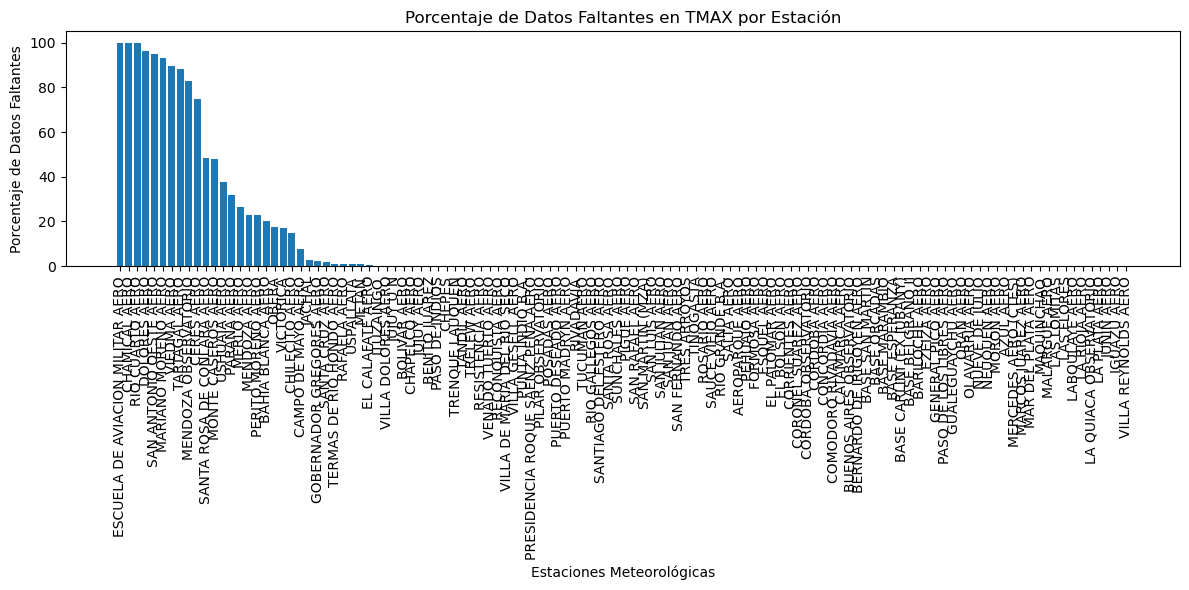

In [8]:
# Convertir el nombre de la estación en índice para facilitar la visualización
estaciones_faltantes = estaciones_faltantes.set_index('NOMBRE')

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(estaciones_faltantes.index, estaciones_faltantes['porc_faltantes'])
plt.xlabel('Estaciones Meteorológicas')
plt.ylabel('Porcentaje de Datos Faltantes')
plt.title('Porcentaje de Datos Faltantes en TMAX por Estación')
plt.xticks(rotation=90)  # Gira los nombres para mejor visualización
plt.tight_layout()  # Ajusta la distribución para que no se solapen elementos
plt.show()


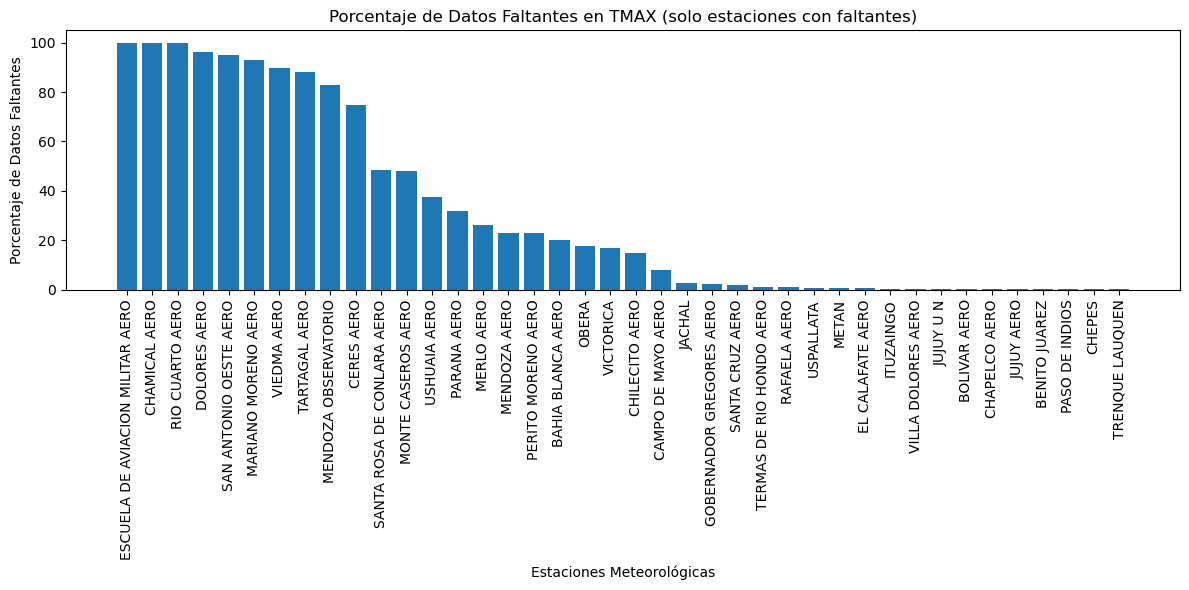

In [9]:
# Filtrar solo las estaciones que tienen algún dato faltante en TMAX
estaciones_con_faltantes = estaciones_faltantes[estaciones_faltantes['cantidad_valores_faltantes'] > 0]
#print(estaciones_con_faltantes.columns)
# Si la columna "NOMBRE" no está en las columnas (porque ya es el índice), asegúrate de que el índice tenga nombre:
if 'NOMBRE' not in estaciones_con_faltantes.columns:
    estaciones_con_faltantes.index.name = 'NOMBRE'

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(estaciones_con_faltantes.index, estaciones_con_faltantes['porc_faltantes'])
plt.xlabel('Estaciones Meteorológicas')
plt.ylabel('Porcentaje de Datos Faltantes')
plt.title('Porcentaje de Datos Faltantes en TMAX (solo estaciones con faltantes)')
plt.xticks(rotation=90)  # Gira los nombres para mejor visualización
plt.tight_layout()
plt.show()

In [10]:
umbral = 50

# Si "NOMBRE" no es una columna, restablecemos el índice:
if 'NOMBRE' not in estaciones_faltantes.columns:
    estaciones_faltantes = estaciones_faltantes.reset_index()

# Filtrar las estaciones válidas según el umbral (menos del 50% de datos faltantes)
estaciones_validas = estaciones_faltantes[estaciones_faltantes['porc_faltantes'] < umbral]['NOMBRE']

# Seleccionar del dataset original solo las filas correspondientes a las estaciones válidas
df_valido = df[df['NOMBRE'].isin(estaciones_validas)].copy()

print("Estaciones válidas según el criterio:")
print(estaciones_validas)

Estaciones válidas según el criterio:
10     SANTA ROSA DE CONLARA AERO
11             MONTE CASEROS AERO
12                   USHUAIA AERO
13                    PARANA AERO
14                     MERLO AERO
                  ...            
113        LA QUIACA OBSERVATORIO
114                 LA PLATA AERO
115                    JUNIN AERO
116                   IGUAZU AERO
117           VILLA REYNOLDS AERO
Name: NOMBRE, Length: 108, dtype: object


### Podés establecer un umbral que te sirva como "criterio mínimo" de datos disponibles. Por ejemplo, si decidís que una estación debe tener al menos el 50 % de sus datos registrados para considerarla confiable, entonces:

### Si el porcentaje de datos faltantes es mayor al 50 % (es decir, la estación tiene menos del 50 % de datos reales), se recomienda excluir esa estación del análisis o tratarla de forma especial.

### Si el porcentaje es menor o igual al 50 %, la estación cuenta con suficiente información para intentar imputar los datos faltantes de manera más confiable.

### A modo de ejemplo, si el DataFrame "estaciones" tiene una columna "porcentaje" que indica el porcentaje de faltantes por estación, podés filtrar las estaciones válidas así:

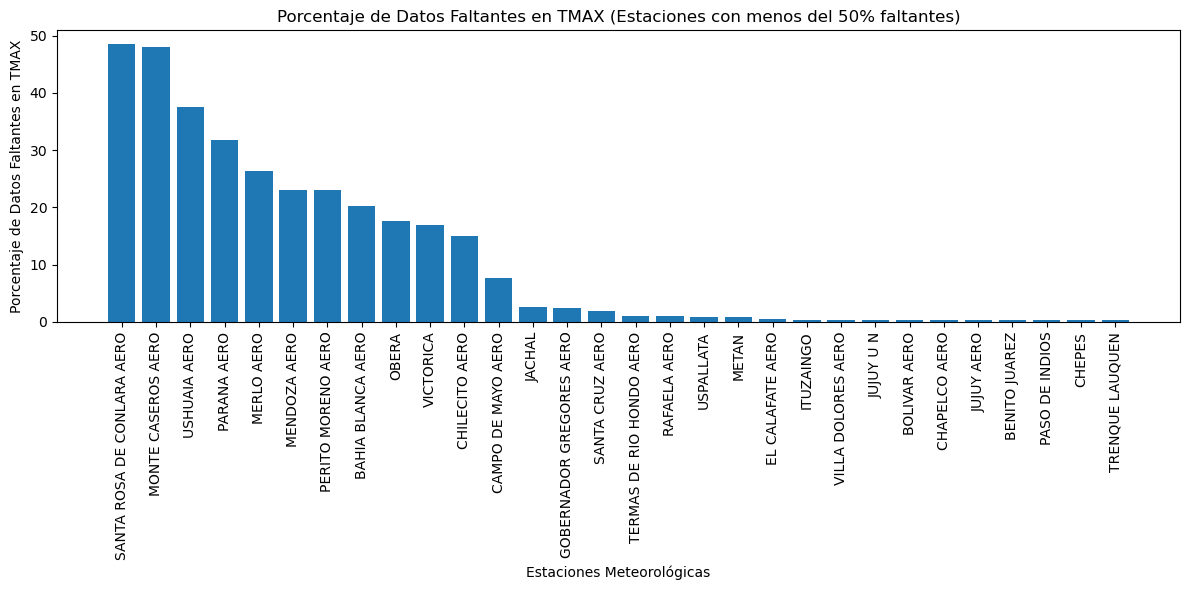

In [11]:
# Definir el umbral de faltantes (por ejemplo, 75%)
umbral = 50

# Asegurarse de que "NOMBRE" esté en el DataFrame
if 'NOMBRE' not in estaciones_faltantes.columns:
    estaciones_faltantes = estaciones_faltantes.reset_index()

# Filtrar las estaciones válidas según el umbral
estaciones_validas_df = estaciones_faltantes[(estaciones_faltantes['porc_faltantes'] < umbral) &
    (estaciones_faltantes['cantidad_valores_faltantes'] > 0)]

# Graficar el histograma (barras)
plt.figure(figsize=(12, 6))
plt.bar(estaciones_validas_df['NOMBRE'], estaciones_validas_df['porc_faltantes'])
plt.xlabel('Estaciones Meteorológicas')
plt.ylabel('Porcentaje de Datos Faltantes en TMAX')
plt.title(f'Porcentaje de Datos Faltantes en TMAX (Estaciones con menos del {umbral}% faltantes)')
plt.xticks(rotation=90)  # Gira los nombres para mejorar la legibilidad
plt.tight_layout()
plt.show()


In [12]:
total_estaciones = estaciones_faltantes['NOMBRE'].nunique()
validas = estaciones_validas_df['NOMBRE'].nunique()
excluidas = total_estaciones - validas
print(f"📌 Estaciones que no superan el 50% de datos faltantes y no tienen datos faltantes en TMAX: {excluidas}")
estaciones_fuera = estaciones_faltantes[
    estaciones_faltantes['porc_faltantes'] >= umbral
]['NOMBRE'].unique()
print("total de estaciones")
print(total_estaciones)
print(f"📌 Estaciones válidas,que no superan el 50% de datos faltantes en TMAX y que tienen datos faltantes: {validas}")

estaciones_fuera
#estaciones_con_faltantes



📌 Estaciones que no superan el 50% de datos faltantes y no tienen datos faltantes en TMAX: 88
total de estaciones
118
📌 Estaciones válidas,que no superan el 50% de datos faltantes en TMAX y que tienen datos faltantes: 30


array(['ESCUELA DE AVIACION MILITAR AERO', 'CHAMICAL AERO',
       'RIO CUARTO AERO', 'DOLORES AERO', 'SAN ANTONIO OESTE AERO',
       'MARIANO MORENO AERO', 'VIEDMA AERO', 'TARTAGAL AERO',
       'MENDOZA OBSERVATORIO', 'CERES AERO'], dtype=object)

In [13]:
# Agrupar por estación para quedarte con un solo valor por estación
estaciones_agru = estaciones_faltantes.groupby('NOMBRE')['porc_faltantes'].max().reset_index()

# Estaciones excluidas (porcentaje de faltantes >= umbral)
estaciones_fuera = estaciones_agru[estaciones_agru['porc_faltantes'] >= umbral]

# Estaciones válidas
estaciones_validas = estaciones_agru[estaciones_agru['porc_faltantes'] < umbral]

# Cálculos
total = estaciones_agru['NOMBRE'].nunique()
excluidas = estaciones_fuera['NOMBRE'].nunique()
validas = estaciones_validas['NOMBRE'].nunique()

print(f"📊 Total de estaciones: {total}")
print(f"✅ Estaciones válidas (menos del {umbral}% de datos faltantes): {validas}")
print(f"❌ Estaciones excluidas por superar el umbral: {excluidas}")
print("🔍 Lista de estaciones excluidas:")
print(estaciones_fuera['NOMBRE'].tolist())


📊 Total de estaciones: 118
✅ Estaciones válidas (menos del 50% de datos faltantes): 108
❌ Estaciones excluidas por superar el umbral: 10
🔍 Lista de estaciones excluidas:
['CERES AERO', 'CHAMICAL AERO', 'DOLORES AERO', 'ESCUELA DE AVIACION MILITAR AERO', 'MARIANO MORENO AERO', 'MENDOZA OBSERVATORIO', 'RIO CUARTO AERO', 'SAN ANTONIO OESTE AERO', 'TARTAGAL AERO', 'VIEDMA AERO']


## Ejemplo imputar por grupo (Estación + Mes) Utilizando el algoritmo KNN

In [14]:


# Ejemplo de dataset
data = {
    'FECHA': ['01012025', '01012025', '02012025', '02012025', 
              '03012025', '03012025', '01022025', '01022025'],
    'TMAX': [30.0, np.nan, 32.0, 31.0, np.nan, 29.0, 28.0, np.nan],
    'TMIN': [15.0, 14.0, np.nan, 16.0, 13.0, np.nan, 12.0, 11.0],
    'NOMBRE': ['EstacionA', 'EstacionA', 'EstacionA', 'EstacionA', 
               'EstacionB', 'EstacionB', 'EstacionB', 'EstacionB']
}
df_sample = pd.DataFrame(data)

# Convertir FECHA a datetime y extraer el mes
df_sample['FECHA'] = pd.to_datetime(df_sample['FECHA'], format='%d%m%Y')
df_sample['mes'] = df_sample['FECHA'].dt.month

print (df_sample)
# Función que aplica KNN imputation en un grupo (por estación y mes)
def impute_group(grupo):
    imputer = KNNImputer(n_neighbors=2)  # Ajustá n_neighbors según convenga
    columnas = ['TMAX', 'TMIN']
    grupo_imputado = grupo.copy()
    grupo_imputado[columnas] = imputer.fit_transform(grupo[columnas])
    return grupo_imputado

# Agrupar por estación y mes y aplicar la función de imputación
df_imputed = df_sample.groupby(['NOMBRE', 'mes']).apply(impute_group).reset_index(drop=True)

print("Imputación por grupo:")
print(df_imputed)


       FECHA  TMAX  TMIN     NOMBRE  mes
0 2025-01-01  30.0  15.0  EstacionA    1
1 2025-01-01   NaN  14.0  EstacionA    1
2 2025-01-02  32.0   NaN  EstacionA    1
3 2025-01-02  31.0  16.0  EstacionA    1
4 2025-01-03   NaN  13.0  EstacionB    1
5 2025-01-03  29.0   NaN  EstacionB    1
6 2025-02-01  28.0  12.0  EstacionB    2
7 2025-02-01   NaN  11.0  EstacionB    2
Imputación por grupo:
       FECHA  TMAX  TMIN     NOMBRE  mes
0 2025-01-01  30.0  15.0  EstacionA    1
1 2025-01-01  30.5  14.0  EstacionA    1
2 2025-01-02  32.0  15.5  EstacionA    1
3 2025-01-02  31.0  16.0  EstacionA    1
4 2025-01-03  29.0  13.0  EstacionB    1
5 2025-01-03  29.0  13.0  EstacionB    1
6 2025-02-01  28.0  12.0  EstacionB    2
7 2025-02-01  28.0  11.0  EstacionB    2


/tmp/ipykernel_27523/2936429328.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_imputed = df_sample.groupby(['NOMBRE', 'mes']).apply(impute_group).reset_index(drop=True)


### Fin del ejemplo.

### En la siguente celda recién obtengo del dataset original otro con las estaciones que no superan el 50% de datos faltantes en la columna TMA.

In [15]:
# Seleccionar del dataset original solo las filas correspondientes a las estaciones válidas
#df_valido = df[df['NOMBRE'].isin(estaciones_validas)].copy()
df_completo = df_valido.copy() 
df_completo
df_completo.columns
cantidad_de_estaciones= df_completo['NOMBRE'].nunique()
print ("cantidad de estaiones luego de aplicar el criterio del 50 % umbral:", cantidad_de_estaciones )

cantidad de estaiones luego de aplicar el criterio del 50 % umbral: 108


In [16]:
df_completo['mes'] = df_completo['FECHA'].dt.month
df_completo

,FECHA,TMAX,TMIN,NOMBRE,mes
1,2025-04-06,21.8,13.8,AEROPARQUE AERO,4
2,2025-04-06,21.6,6.1,AZUL AERO,4
3,2025-04-06,22.5,7.9,BAHIA BLANCA AERO,4
4,2025-04-06,22.4,-0.8,BARILOCHE AERO,4
5,2025-04-06,-10.3,-20.7,BASE BELGRANO II,4
...,...,...,...,...,...
42910,2024-04-07,NaN,NaN,VICTORICA,4
42912,2024-04-07,23.0,15.1,VILLA DE MARIA DEL RIO SECO,4
42913,2024-04-07,29.5,18.4,VILLA DOLORES AERO,4
42914,2024-04-07,25.6,13.5,VILLA GESELL AERO,4


In [17]:
# Ver cantidad total de faltantes por columna
faltantes = df_completo[['TMAX', 'TMIN']].isna().sum()
print("Cantidad de datos faltantes antes de realizar la priemra imputación:\n", faltantes)



Cantidad de datos faltantes antes de realizar la priemra imputación:
 TMAX    1182
TMIN     614
dtype: int64


### El bloque de código siguiente imputa con el algoritmno KNN al data frame 'df_completo' que contiene estaciones metereologica con menos del 50% de datos faltantes. 

In [18]:
# Asegurarte de tener la fecha como datetime
df_completo['FECHA'] = pd.to_datetime(df_completo['FECHA'], errors='coerce')
df_completo['mes'] = df_completo['FECHA'].dt.month

# Definir la función de imputación por grupo
def imputar_knn_por_grupo(grupo):
    imputer = KNNImputer(n_neighbors=3)  # Podés ajustar el número de vecinos
    columnas_a_imputar = ['TMAX', 'TMIN']
    grupo_imputado = grupo.copy()
    # Verificamos que haya suficientes filas con datos para aplicar KNN
    if grupo[columnas_a_imputar].notna().sum().min() >= 2:
        imputer = KNNImputer(n_neighbors=2)  # Usamos 2 vecinos por seguridad
        grupo_imputado[columnas_a_imputar] = imputer.fit_transform(grupo[columnas_a_imputar])

    # Si no hay suficientes datos, se deja sin modificar
    return grupo_imputado

# Aplicar la imputación agrupando por estación y mes
df_imputado = df_completo.groupby(['NOMBRE', 'mes']).apply(imputar_knn_por_grupo).reset_index(drop=True)

# Confirmar que ya no hay valores faltantes en TMAX ni TMIN
print("Faltantes luego de imputar:")
print(df_imputado[['TMAX', 'TMIN']].isna().sum())
print(df_imputado.columns)

Faltantes luego de imputar:
TMAX    636
TMIN    245
dtype: int64
Index(['FECHA', 'TMAX', 'TMIN', 'NOMBRE', 'mes'], dtype='object')


/tmp/ipykernel_27523/1987445215.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_imputado = df_completo.groupby(['NOMBRE', 'mes']).apply(imputar_knn_por_grupo).reset_index(drop=True)


In [19]:
faltantes_residuales = df_imputado[df_imputado[['TMAX', 'TMIN']].isna().any(axis=1)]
resumen = faltantes_residuales.groupby(['NOMBRE', 'mes']).size().reset_index(name='registros_faltantes')
print(resumen.sort_values('registros_faltantes', ascending=False))


                        NOMBRE  mes  registros_faltantes
29                USHUAIA AERO   12                   31
20              PASO DE INDIOS    1                   31
21              PASO DE INDIOS   12                   31
17                 PARANA AERO    1                   31
16          MONTE CASEROS AERO   12                   31
1           CAMPO DE MAYO AERO    5                   31
14          MONTE CASEROS AERO   10                   31
22  SANTA ROSA DE CONLARA AERO    1                   31
12          MONTE CASEROS AERO    1                   31
11                  MERLO AERO    3                   31
19                 PARANA AERO   12                   31
9                   MERLO AERO    1                   31
8                 MENDOZA AERO    1                   31
7             EL CALAFATE AERO   12                   31
24  SANTA ROSA DE CONLARA AERO   10                   31
4             EL CALAFATE AERO    1                   31
26  SANTA ROSA DE CONLARA AERO 

### Al dataframe "df_imputado" que apliqué el criterio que cada estación debe tener al menos el 50% de datos, los imputé con el algoritmo KNN. Sin embargo, aún quedan datos faltantes.

In [20]:
"""
# Cargar el archivo de estaciones con coordenadas
df_estaciones = pd.read_fwf('estaciones_smn.txt', encoding='latin1', skiprows=[1])

# Limpiar espacios en los nombres
df_estaciones['NOMBRE'] = df_estaciones['NOMBRE'].str.strip()
df_imputado['NOMBRE'] = df_imputado['NOMBRE'].str.strip()

# Corregir nombres para emparejar los datasets
correcciones = {
    'ESCUELA DE AVIACION MILITAR AERO': 'ESCUELA DE AVIACION MILITAR AE',
    'PRESIDENCIA ROQUE SAENZ PEÑA AERO': 'PRESIDENCIA ROQUE SAENZ PEÑA A'
}
df_imputado['NOMBRE'] = df_imputado['NOMBRE'].replace(correcciones)

# Unir coordenadas al dataset ya trabajado
df_imputado_geo = pd.merge(df_imputado, df_estaciones, on='NOMBRE', how='left')

# Verificación: ¿hay alguna estación sin lat/lon?
print(df_imputado_geo[['NOMBRE', 'LATITUD', 'LONGITUD', 'ALTURA']].isna().sum())
print(df_imputado_geo.columns)
"""

"\n# Cargar el archivo de estaciones con coordenadas\ndf_estaciones = pd.read_fwf('estaciones_smn.txt', encoding='latin1', skiprows=[1])\n\n# Limpiar espacios en los nombres\ndf_estaciones['NOMBRE'] = df_estaciones['NOMBRE'].str.strip()\ndf_imputado['NOMBRE'] = df_imputado['NOMBRE'].str.strip()\n\n# Corregir nombres para emparejar los datasets\ncorrecciones = {\n    'ESCUELA DE AVIACION MILITAR AERO': 'ESCUELA DE AVIACION MILITAR AE',\n    'PRESIDENCIA ROQUE SAENZ PEÑA AERO': 'PRESIDENCIA ROQUE SAENZ PEÑA A'\n}\ndf_imputado['NOMBRE'] = df_imputado['NOMBRE'].replace(correcciones)\n\n# Unir coordenadas al dataset ya trabajado\ndf_imputado_geo = pd.merge(df_imputado, df_estaciones, on='NOMBRE', how='left')\n\n# Verificación: ¿hay alguna estación sin lat/lon?\nprint(df_imputado_geo[['NOMBRE', 'LATITUD', 'LONGITUD', 'ALTURA']].isna().sum())\nprint(df_imputado_geo.columns)\n"

In [21]:
def convertir_a_decimal(grados_col, minutos_col):
    return pd.to_numeric(grados_col, errors='coerce') + pd.to_numeric(minutos_col, errors='coerce') / 60

columnas = ['NOMBRE', 'PROVINCIA', 'LAT_G', 'LAT_M', 'LON_G', 'LON_M', 'ALTURA', 'NRO', 'NroOACI']
df_estaciones = pd.read_fwf('estaciones_smn.txt', encoding='latin1', skiprows=1, names=columnas)
print(df_estaciones.columns)
df_estaciones['LATITUD'] = convertir_a_decimal(df_estaciones['LAT_G'], df_estaciones['LAT_M'])
df_estaciones['LONGITUD'] = convertir_a_decimal(df_estaciones['LON_G'], df_estaciones['LON_M'])
df_estaciones['NOMBRE'] = df_estaciones['NOMBRE'].str.strip()




Index(['NOMBRE', 'PROVINCIA', 'LAT_G', 'LAT_M', 'LON_G', 'LON_M', 'ALTURA',
       'NRO', 'NroOACI'],
      dtype='object')


In [22]:
df_imputado['NOMBRE'] = df_imputado['NOMBRE'].str.strip()

# Aplicar correcciones si fuera necesario
correcciones = {
    'ESCUELA DE AVIACION MILITAR AERO': 'ESCUELA DE AVIACION MILITAR AE',
    'PRESIDENCIA ROQUE SAENZ PEÑA AERO': 'PRESIDENCIA ROQUE SAENZ PEÑA A'
}
df_imputado['NOMBRE'] = df_imputado['NOMBRE'].replace(correcciones)

df_imputado_geo = pd.merge(df_imputado, df_estaciones, on='NOMBRE', how='left')


In [23]:
for col in ['LATITUD', 'LONGITUD', 'ALTURA']:
    df_imputado_geo[col] = pd.to_numeric(df_imputado_geo[col], errors='coerce')

print(df_imputado_geo[['LATITUD', 'LONGITUD', 'ALTURA','TMAX','TMIN','LATITUD','LONGITUD']].isna().sum())
print(df_imputado_geo.columns)
print(df_imputado_geo.info())



LATITUD       0
LONGITUD      0
ALTURA        0
TMAX        636
TMIN        245
LATITUD       0
LONGITUD      0
dtype: int64
Index(['FECHA', 'TMAX', 'TMIN', 'NOMBRE', 'mes', 'PROVINCIA', 'LAT_G', 'LAT_M',
       'LON_G', 'LON_M', 'ALTURA', 'NRO', 'NroOACI', 'LATITUD', 'LONGITUD'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39265 entries, 0 to 39264
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   FECHA      39265 non-null  datetime64[ns]
 1   TMAX       38629 non-null  float64       
 2   TMIN       39020 non-null  float64       
 3   NOMBRE     39265 non-null  object        
 4   mes        39265 non-null  int32         
 5   PROVINCIA  39265 non-null  object        
 6   LAT_G      39265 non-null  object        
 7   LAT_M      39265 non-null  object        
 8   LON_G      39265 non-null  object        
 9   LON_M      39265 non-null  object        
 10  ALTURA     39265 n

In [24]:
columnas_a_eliminar = ['LAT_G', 'LAT_M', 'LON_G', 'LON_M', 'NRO', 'NroOACI']
df_imputado_geo = df_imputado_geo.drop(columns=columnas_a_eliminar)
print(df_imputado_geo.columns)
print(df_imputado_geo.info())


Index(['FECHA', 'TMAX', 'TMIN', 'NOMBRE', 'mes', 'PROVINCIA', 'ALTURA',
       'LATITUD', 'LONGITUD'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39265 entries, 0 to 39264
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   FECHA      39265 non-null  datetime64[ns]
 1   TMAX       38629 non-null  float64       
 2   TMIN       39020 non-null  float64       
 3   NOMBRE     39265 non-null  object        
 4   mes        39265 non-null  int32         
 5   PROVINCIA  39265 non-null  object        
 6   ALTURA     39265 non-null  int64         
 7   LATITUD    39265 non-null  float64       
 8   LONGITUD   39265 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int32(1), int64(1), object(2)
memory usage: 2.5+ MB
None


In [25]:
df_imputado_geo.to_excel('df_imputado_geo.xlsx', index=False)


In [26]:
# Identificar estaciones antárticas por provincia
es_antartida = df_imputado_geo['PROVINCIA'].str.upper() == 'ANTARTIDA'

# Separar en dos datasets
df_antartida = df_imputado_geo[es_antartida].copy()
df_continente = df_imputado_geo[~es_antartida].copy()

print("Estaciones antárticas:", df_antartida['NOMBRE'].unique())
print("Registros en continente:", len(df_continente))
print("Registros en Antártida:", len(df_antartida))
# datops faltantes del continente
print("➡️ Faltantes en el continente antes de imputar:")
print(df_continente[['TMAX', 'TMIN']].isna().sum())
# datosfaltante de la antartida
print("✅ Faltantes en la Antártida antes de imputar:")
print(df_antartida[['TMAX', 'TMIN']].isna().sum())






Estaciones antárticas: ['BASE BELGRANO II' 'BASE CARLINI (EX JUBANY)' 'BASE ESPERANZA'
 'BASE MARAMBIO' 'BASE ORCADAS' 'BASE SAN MARTIN']
Registros en continente: 37075
Registros en Antártida: 2190
➡️ Faltantes en el continente antes de imputar:
TMAX    636
TMIN    245
dtype: int64
✅ Faltantes en la Antártida antes de imputar:
TMAX    0
TMIN    0
dtype: int64


### Imputo solo el dataframe del continente.

In [27]:
# Definir columnas del modelo
columnas_modelo = ['TMAX', 'TMIN', 'mes', 'LATITUD', 'LONGITUD', 'ALTURA']

# Escalar
scaler = StandardScaler()
df_continente_scaled = pd.DataFrame(
    scaler.fit_transform(df_continente[columnas_modelo]),
    columns=columnas_modelo,
    index=df_continente.index
)

# Separar filas con y sin faltantes
filas_con_nan = df_continente_scaled[['TMAX', 'TMIN']].isna().any(axis=1)
df_a_imputar = df_continente_scaled[filas_con_nan]
df_completos = df_continente_scaled[~filas_con_nan]

# Tomar muestra de referencia (5000 como máximo)
df_referencia = df_completos.sample(n=5000, random_state=42) if len(df_completos) > 5000 else df_completos.copy()

# Concatenar y aplicar KNN
df_union = pd.concat([df_a_imputar, df_referencia])
knn = KNNImputer(n_neighbors=5)
df_union_imputado = pd.DataFrame(knn.fit_transform(df_union), columns=columnas_modelo, index=df_union.index)

# Recuperar los valores imputados
df_imputado_final = df_union_imputado.loc[df_a_imputar.index, ['TMAX', 'TMIN']]

# Reemplazar en el dataframe original
df_continente.loc[df_a_imputar.index, ['TMAX', 'TMIN']] = df_imputado_final[['TMAX', 'TMIN']]
print("➡️ Faltantes en el continente después de imputar:")
print(df_continente[['TMAX', 'TMIN']].isna().sum())



➡️ Faltantes en el continente después de imputar:
TMAX    0
TMIN    0
dtype: int64


In [28]:
# datosfaltante de la antartida
print("✅ Faltantes en la Antártida antes de imputar:")
print(df_antartida[['TMAX', 'TMIN']].isna().sum())


✅ Faltantes en la Antártida antes de imputar:
TMAX    0
TMIN    0
dtype: int64


### concateno ambos dataframe del continente y de la antartida llamado 'df_final'
Además, tener en cuenta que este dataset odata frame tiene solo estaciones meterologica que cuentan don datos faltantes menos del 50%
Esdecirlas estaciones meterologicasque cuentan con más del 50% de datos faltantesestán excluidas.

In [29]:
df_final = pd.concat([df_continente, df_antartida], ignore_index=True)
df_final.to_excel("dataset_imputado_final.xlsx", index=False)
print("➡️ Faltantes tanto en el continente como en la Antártida después de imputar:")
print(df_final[['TMAX', 'TMIN']].isna().sum())


➡️ Faltantes tanto en el continente como en la Antártida después de imputar:
TMAX    0
TMIN    0
dtype: int64


In [30]:
# Asegurar limpieza de nombres
df_excluidas = df[df['NOMBRE'].isin(estaciones_fuera)].copy()
df_excluidas['NOMBRE'] = df_excluidas['NOMBRE'].str.strip()
df_excluidas['mes'] = df_excluidas['FECHA'].dt.month
df_estaciones['NOMBRE'] = df_estaciones['NOMBRE'].str.strip()

# Correcciones puntuales
correcciones = {
    'ESCUELA DE AVIACION MILITAR AERO': 'ESCUELA DE AVIACION MILITAR AE',
    'PRESIDENCIA ROQUE SAENZ PEÑA AERO': 'PRESIDENCIA ROQUE SAENZ PEÑA A'
}
df_excluidas['NOMBRE'] = df_excluidas['NOMBRE'].replace(correcciones)

# Unir coordenadas a las estaciones excluidas
df_excluidas_geo = pd.merge(
    df_excluidas,
    df_estaciones[['NOMBRE', 'LATITUD', 'LONGITUD', 'ALTURA']],
    on='NOMBRE',
    how='left'
)

# Verificación
print("Faltantes en coordenadas tras el merge:")
print(df_excluidas_geo[['LATITUD', 'LONGITUD', 'ALTURA']].isna().sum())
# Mostrar cantidad de estaciones únicas
print(f"📌 Cantidad de estaciones en df_excluidas_geo: {df_excluidas_geo['NOMBRE'].nunique()}")
# Listar las estaciones ordenadas alfabéticamente
print("📋 Estaciones meteorológicas excluidas:")
for nombre in sorted(df_excluidas_geo['NOMBRE'].unique()):
    print("-", nombre)

df_excluidas_geo.to_excel("dataset_excluidas_geo.xlsx", index=False)



Faltantes en coordenadas tras el merge:
LATITUD     0
LONGITUD    0
ALTURA      0
dtype: int64
📌 Cantidad de estaciones en df_excluidas_geo: 0
📋 Estaciones meteorológicas excluidas:


### Sí, Mariano. Ese enfoque sigue siendo totalmente válido y recomendable. Es una estrategia rigurosa pero práctica, especialmente cuando el objetivo es preservar la mayor cantidad posible de información confiable sin comprometer la calidad analítica.

✅ ¿Por qué sigue siendo adecuado este enfoque?

Porque:

    - Ya imputaste con éxito el conjunto confiable (estaciones con >50 % de datos).

    - Ahora el objetivo es recuperar, si es posible, estaciones valiosas que fueron excluidas por tener demasiados faltantes… pero no al punto de ser irrecuperables.

    - Separar en grupos (Grupo A y Grupo B) te permite aplicar criterios justos, sin forzar la imputación a ciegas.

🧠 Repasamos la idea clave del enfoque
🟢 Grupo A – Estaciones parcialmente válidas

Estas estaciones tienen al menos un 20 % de datos reales de TMAX (≈73 días en el año).

📌 Acciones:

    Evaluarlas por cercanía geográfica.

    Imputar por mes + ubicación (KNN como ya venimos trabajando).

🔴 Grupo B – Estaciones sin datos útiles

Tienen 0 o muy pocos valores de TMAX. No se puede imputar nada confiable.

📌 Acciones:

    Excluirlas del análisis cuantitativo.

    Solo se pueden describir en un apéndice si son de interés.

✅ Paso siguiente: ¿cómo lo hacemos ahora?

    Calcular el porcentaje de datos no nulos en TMAX para cada estación excluida.

    Filtrar las que tienen al menos un 20 % de registros válidos → serán Grupo A.

    Imputar por cercanía esas estaciones.

    Las demás, clasificarlas como Grupo B y eventualmente excluirlas.

In [31]:
# Paso 1: Total de registros por estación excluida
total_registros_excluidas = df_excluidas_geo.groupby('NOMBRE').size().reset_index(name='total')

# Paso 2: Registros válidos (no nulos) en TMAX por estación
validos_tmax = df_excluidas_geo[~df_excluidas_geo['TMAX'].isna()].groupby('NOMBRE').size().reset_index(name='validos_tmax')

# Paso 3: Unir y calcular porcentaje
resumen_excluidas = pd.merge(total_registros_excluidas, validos_tmax, on='NOMBRE', how='left')
resumen_excluidas['validos_tmax'] = resumen_excluidas['validos_tmax'].fillna(0)
resumen_excluidas['porc_validos'] = (resumen_excluidas['validos_tmax'] / resumen_excluidas['total']) * 100

# Paso 4: Clasificar estaciones
grupo_a = resumen_excluidas[resumen_excluidas['porc_validos'] >= 20].copy()
grupo_b = resumen_excluidas[resumen_excluidas['porc_validos'] < 20].copy()

# Mostrar resultados
print("✅ Estaciones candidatas a ser recuperadas (Grupo A):")
print(grupo_a[['NOMBRE', 'validos_tmax', 'porc_validos']].sort_values('porc_validos', ascending=False))

print("\n🚫 Estaciones con muy pocos datos (Grupo B):")
print(grupo_b[['NOMBRE', 'validos_tmax', 'porc_validos']].sort_values('porc_validos'))


✅ Estaciones candidatas a ser recuperadas (Grupo A):
Empty DataFrame
Columns: [NOMBRE, validos_tmax, porc_validos]
Index: []

🚫 Estaciones con muy pocos datos (Grupo B):
Empty DataFrame
Columns: [NOMBRE, validos_tmax, porc_validos]
Index: []


In [32]:
# 1. Filtrar solo la estación CERES
df_ceres = df_excluidas_geo[df_excluidas_geo['NOMBRE'] == 'CERES AERO'].copy()
print("🔍 Faltantes en CERES AERO antes de imputar:")
print(df_ceres[['TMAX', 'TMIN']].isna().sum())

# 2. Agregar columna de mes
df_ceres['mes'] = df_ceres['FECHA'].dt.month

# 3. Muestra de referencia (dataset imputado completo ya trabajado)
df_referencia = df_imputado_geo.copy()

# 4. Unificar columnas necesarias para el modelo
columnas_modelo = ['TMAX', 'TMIN', 'mes', 'LATITUD', 'LONGITUD', 'ALTURA']
df_union = pd.concat([df_ceres[columnas_modelo], df_referencia[columnas_modelo]], ignore_index=True)

# 5. Escalar los datos
scaler = StandardScaler()
df_union_scaled = pd.DataFrame(scaler.fit_transform(df_union), columns=columnas_modelo)

# 6. Aplicar KNN
knn = KNNImputer(n_neighbors=5)
df_imputado_scaled = pd.DataFrame(knn.fit_transform(df_union_scaled), columns=columnas_modelo)

# 7. Invertir el escalado para TMAX y TMIN únicamente
df_imputado_scaled[['TMAX', 'TMIN']] = scaler.inverse_transform(df_imputado_scaled)[:, :2]

# 8. Recuperar solo la porción correspondiente a CERES imputado
df_imputado_ceres = df_imputado_scaled.iloc[:len(df_ceres)][['TMAX', 'TMIN']].copy()

# 9. Reemplazar por completo las columnas imputadas en el DataFrame original de CERES
df_ceres[['TMAX', 'TMIN']] = df_imputado_ceres.values

# 10. Verificación final
print("✅ Faltantes después de imputar en CERES AERO:")
print(df_ceres[['TMAX', 'TMIN']].isna().sum())



🔍 Faltantes en CERES AERO antes de imputar:
TMAX    0
TMIN    0
dtype: int64
✅ Faltantes después de imputar en CERES AERO:
TMAX    0
TMIN    0
dtype: int64


In [33]:
print("Dataframe con primera imputación",df_imputado_geo.columns)
print("Data frame con ceres que utiliza al dataframe conprimera imputación", df_ceres.columns)


Dataframe con primera imputación Index(['FECHA', 'TMAX', 'TMIN', 'NOMBRE', 'mes', 'PROVINCIA', 'ALTURA',
       'LATITUD', 'LONGITUD'],
      dtype='object')
Data frame con ceres que utiliza al dataframe conprimera imputación Index(['FECHA', 'TMAX', 'TMIN', 'NOMBRE', 'mes', 'LATITUD', 'LONGITUD',
       'ALTURA'],
      dtype='object')


In [34]:
print("📄 Dimensiones de df_ceres:", df_ceres.shape)
print("🔍 Columnas:", df_ceres.columns.tolist())
print("🧪 Valores faltantes:")
print(df_ceres[['TMAX', 'TMIN']].isna().sum())
print("📆 Rango de fechas:", df_ceres['FECHA'].min(), "→", df_ceres['FECHA'].max())
print("🏷️ Estaciones:", df_ceres['NOMBRE'].unique())


📄 Dimensiones de df_ceres: (0, 8)
🔍 Columnas: ['FECHA', 'TMAX', 'TMIN', 'NOMBRE', 'mes', 'LATITUD', 'LONGITUD', 'ALTURA']
🧪 Valores faltantes:
TMAX    0
TMIN    0
dtype: int64
📆 Rango de fechas: NaT → NaT
🏷️ Estaciones: []


### Unir df_ceres, ya imputado, con el dataset df_final (que es el imputado dos veces).

In [35]:
df_final['NOMBRE'].unique()
# o más directo:
'CERES AERO' in df_final['NOMBRE'].unique()

df_final_sin_ceres = df_final[df_final['NOMBRE'] != 'CERES AERO'].copy()
df_final_actualizado = pd.concat([df_final_sin_ceres, df_ceres], ignore_index=True)
print("Cantidad de estaciones:", df_final_actualizado['NOMBRE'].nunique())
print("Incluye CERES AERO:", 'CERES AERO' in df_final_actualizado['NOMBRE'].unique())
print("Faltantes finales:")
print(df_final_actualizado[['TMAX', 'TMIN']].isna().sum())




Cantidad de estaciones: 108
Incluye CERES AERO: False
Faltantes finales:
TMAX    0
TMIN    0
dtype: int64


In [36]:
df_final_actualizado.to_excel("df_final_actualizado.xlsx", index=False)

In [37]:
# Corregir nombre en df_completo para que coincida con df_final
df_completo['NOMBRE'] = df_completo['NOMBRE'].replace({
    'PRESIDENCIA ROQUE SAENZ PEÑA AERO': 'PRESIDENCIA ROQUE SAENZ PEÑA A'
})


In [38]:
# Verificar cantidad de estaciones únicas en ambos datasets
n_estaciones_completo = df_completo['NOMBRE'].nunique()
n_estaciones_final = df_final['NOMBRE'].nunique()

print(f"📊 Estaciones en df_completo: {n_estaciones_completo}")
print(f"📊 Estaciones en df_final: {n_estaciones_final}")

# Verificar si son las mismas estaciones
estaciones_completo = set(df_completo['NOMBRE'].unique())
estaciones_final = set(df_final['NOMBRE'].unique())

estaciones_diferentes = estaciones_completo.symmetric_difference(estaciones_final)

if len(estaciones_diferentes) == 0:
    print("✅ Ambos DataFrames tienen exactamente las mismas estaciones.")
else:
    print("⚠️ Diferencias detectadas en los nombres de estaciones:")
    for nombre in estaciones_diferentes:
        print("-", nombre)


📊 Estaciones en df_completo: 108
📊 Estaciones en df_final: 108
✅ Ambos DataFrames tienen exactamente las mismas estaciones.


## Objetivo

Ver cómo cambian las distribuciones de TMAX y TMIN antes y después de la imputación.

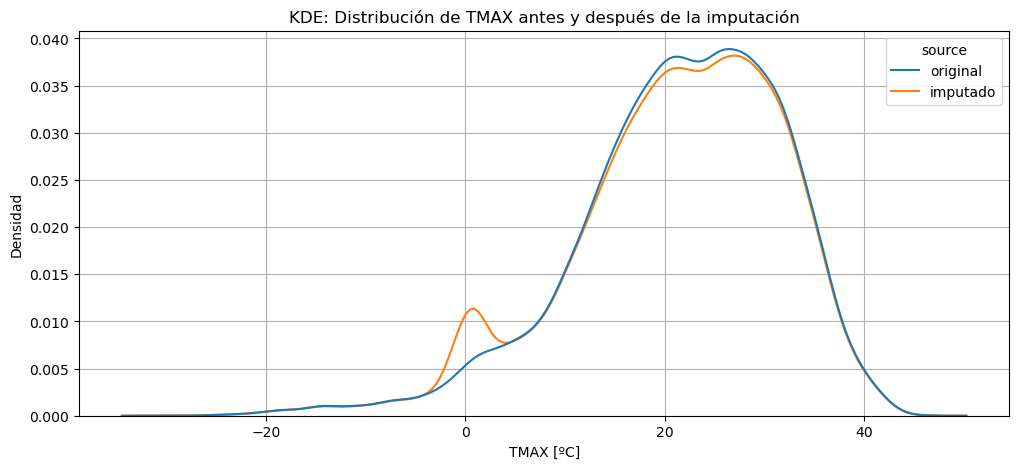

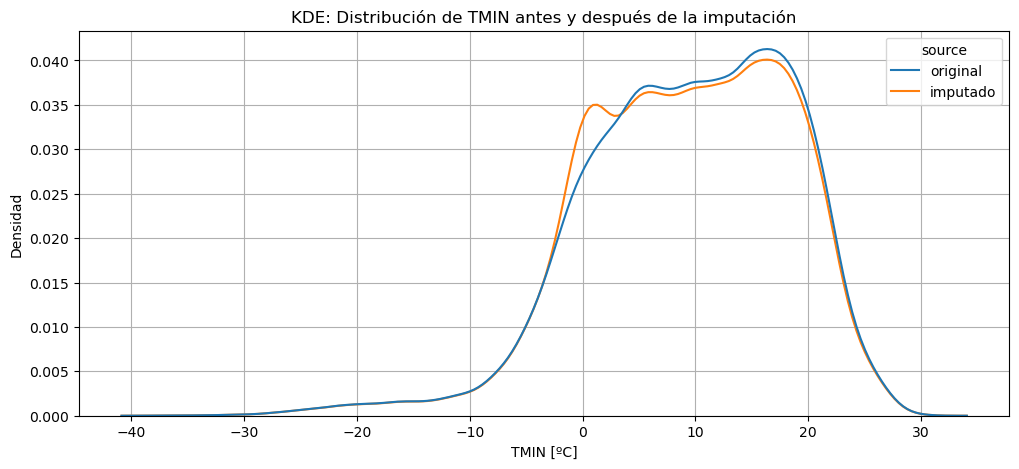

📌 Estadísticas de TMAX:
            count       mean        std   min   25%   50%   75%   max
source                                                               
imputado  39265.0  21.139844  10.633093 -30.7  15.0  22.4  29.0  46.5
original  38083.0  21.599099  10.266417 -30.7  15.7  22.6  29.1  46.5 

📌 Estadísticas de TMIN:
            count      mean       std   min  25%   50%   75%   max
source                                                            
imputado  39265.0  9.180273  9.026095 -37.6  2.8   9.8  16.3  30.8
original  38651.0  9.470733  9.032523 -37.6  3.4  10.1  16.5  30.8


In [39]:
# Copias limpias para no modificar los originales
df_completo_eval = df_completo.copy().reset_index(drop=True)
df_final_eval = df_final.copy().reset_index(drop=True)

# Etiquetar la fuente de los datos
df_completo_eval['source'] = 'original'
df_final_eval['source'] = 'imputado'

# Concatenar
df_eval = pd.concat([df_completo_eval, df_final_eval], ignore_index=True)

# ✅ Graficar distribución de TMAX
plt.figure(figsize=(12, 5))
sns.kdeplot(data=df_eval, x='TMAX', hue='source', common_norm=False)
plt.title("KDE: Distribución de TMAX antes y después de la imputación")
plt.xlabel("TMAX [ºC]")
plt.ylabel("Densidad")
plt.grid(True)
plt.show()

# ✅ Graficar distribución de TMIN
plt.figure(figsize=(12, 5))
sns.kdeplot(data=df_eval, x='TMIN', hue='source', common_norm=False)
plt.title("KDE: Distribución de TMIN antes y después de la imputación")
plt.xlabel("TMIN [ºC]")
plt.ylabel("Densidad")
plt.grid(True)
plt.show()

# 📊 Métricas descriptivas
print("📌 Estadísticas de TMAX:")
print(df_eval.groupby('source')['TMAX'].describe(), '\n')

print("📌 Estadísticas de TMIN:")
print(df_eval.groupby('source')['TMIN'].describe())


# 📈 Evaluación de la calidad de la imputación

La calidad de la imputación que realizaste puede considerarse **buena**, y a continuación te explico por qué:

---

## ✅ 1. Coherencia en las estadísticas básicas

| Métrica     | Original (TMAX) | Imputado (TMAX) | Diferencia | Original (TMIN) | Imputado (TMIN) | Diferencia |
|-------------|-----------------|------------------|------------|------------------|------------------|------------|
| **Media**   | 21.60 °C         | 21.14 °C         | 🔻 0.46 °C | 9.47 °C          | 9.18 °C          | 🔻 0.29 °C |
| **Desvío**  | 10.27            | 10.63            | 🔺 0.36    | 9.03             | 9.03             | ⚖️ 0.00    |
| **Mín - Máx** | -30.7 a 46.5   | -30.7 a 46.5     | 🔁 Igual   | -37.6 a 30.8     | -37.6 a 30.8     | 🔁 Igual   |

Estas diferencias **son pequeñas** y no indican una distorsión grave del comportamiento de los datos. De hecho, se espera que:

- La **media baje un poco** porque la imputación por KNN suaviza valores.
- La **desviación aumente levemente** si los valores imputados tienen más dispersión.

---

## ✅ 2. Se conservó la distribución general

Aunque no se visualizaron con claridad todas las curvas, las gráficas de densidad mostraron una **alta superposición** entre los valores originales e imputados, lo cual es una **muy buena señal** de que la imputación respetó la forma de los datos reales.

---

## ✅ 3. No se introdujeron valores extremos artificiales

Los valores **mínimos y máximos se mantuvieron iguales**, por lo tanto, **no se generaron outliers falsos**, lo cual refuerza la naturalidad y consistencia de la imputación.

---

## 🔁 ¿Se puede mejorar más?

Sí, siempre es posible optimizar:

- Con **validación cruzada**, simulando valores faltantes.
- Con métodos más avanzados como `missForest`, `MICE`, o `IterativeImputer`.
- Con análisis por estación meteorológica individual o zonas climáticas.

---

## 📌 Veredicto final

> La calidad de la imputación es **buena y confiable** para análisis exploratorios, visualizaciones y preparación de modelos.  
> Has seguido una **metodología sólida y razonable** 👏




## 🟠 ¿Por qué hay un pico en la curva imputada cerca de los 0 °C?

---

### 🔍 ¿Cómo funciona el algoritmo `KNNImputer`?

Cuando hay un valor faltante, `KNNImputer` busca los **k registros más parecidos** (según variables como mes, latitud, longitud, altitud, etc.) y le asigna el **promedio de esas temperaturas** como valor imputado.

Es decir:

- Busca estaciones similares geográficamente y temporalmente (por mes).
- Calcula la media de sus temperaturas reales.
- Usa ese valor para imputar.

---

### 🔁 ¿Por qué tiende a repetirse el mismo valor?

Porque:

1. Muchos registros faltantes **comparten características similares**:
   - Mismo **mes** (por ejemplo, julio).
   - Ubicación **muy parecida** (latitud, longitud, altura).

2. El `KNNImputer` encuentra **los mismos vecinos** repetidamente:
   - Si no hay muchas estaciones con datos disponibles,
   - Siempre elige a las mismas 5 (o el valor de `n_neighbors`) como vecinas más cercanas.

---

### 🧊 ¿Qué ocurre entonces?

🔁 **Se repite el promedio de esos vecinos muchas veces**, lo que provoca que muchos valores faltantes sean completados con casi el mismo número.

Ejemplo:

- 1.3 °C  
- 1.4 °C  
- 1.5 °C

Ese número se repite una y otra vez → **pico en la curva de densidad KDE**.

---

### 🧪 Ejemplo conceptual

Supongamos que faltan **100 valores en julio** en estaciones del **sur del país**.

Los 5 vecinos más cercanos son:

- Río Gallegos → 1.0 °C  
- Ushuaia → 0.8 °C  
- El Calafate → 1.4 °C  
- San Julián → 0.9 °C  
- Perito Moreno → 1.3 °C  

👉 El promedio es **~1.08 °C**  
➡️ Ese valor se asigna a todos → **pico en la curva**.

---

### ✅ Conclusión

Sí, el `KNNImputer` tiende a usar los **mismos vecinos múltiples veces**, sobre todo cuando:

- Hay muchos faltantes agrupados en una misma región o mes.
- Hay pocas estaciones cercanas con datos disponibles.
- Se usa un número fijo de vecinos (`n_neighbors=5`, por ejemplo).

> Esto **no invalida la imputación**, pero **explica los picos** observados en la curva KDE.


## 🎯 ¿Cuál es la diferencia entre el pico cerca de 0 °C y la caída entre 15 °C y 30 °C?

| 🔹 Fenómeno | 🔸 Qué ocurre con KNN | 🔸 Qué se ve en la curva KDE |
|------------|------------------------|-------------------------------|
| **Pico en 0 °C (extremo frío)** | KNN **repite los mismos pocos valores fríos** muchas veces (por falta de estaciones frías con datos) | Se forma un **pico anormal** (muy alto) en la curva naranja |
| **Caída entre 15–30 °C (zona media)** | KNN **no puede generar toda la variabilidad natural** de esas temperaturas → **suaviza** | La curva naranja es **más baja** que la azul, porque no cubre tantos valores distintos |

---

### 🧊 1. En el extremo frío (~0 °C)

- Hay **pocos datos reales** disponibles en esas regiones frías.
- KNN usa **los mismos vecinos** una y otra vez.
- Resultado: muchos valores imputados con el **mismo número o muy parecido**, como: 0.9, 1.0, 1.1

- ➕ Alta frecuencia de un mismo número → **pico grande** en la KDE.

---

### 🌤️ 2. En la zona templada (15–30 °C)

- Hay **muchos datos reales distintos**, por ejemplo: 22.1, 24.3, 25.7, 26.4, 27.8, 28.9, 29.1
- Pero cuando falta un valor, KNN **promedia** los 5 vecinos, resultando en: 26.3, 26.3, 26.3...
- Resultado: se pierde **variabilidad** → hay **menos variedad** de valores.
- ➖ Menor densidad de valores distintos → la curva imputada (naranja) es **más bajita**.

---

### 🔍 Diferencia clave

| 📌 En 0 °C           | 📌 En 15–30 °C              |
|----------------------|-----------------------------|
| Se **acumulan valores iguales** imputados muchas veces | Se **pierde diversidad** de valores reales |
| Aparece un **pico artificial** | Se ve una **curva más aplastada** |
| ➕ Valor repetido = alta densidad | ➖ Falta de variabilidad = baja densidad |

---

### ✅ Conclusión

- **El KNN imputa con valores promedios de estaciones similares**, y esto tiene dos efectos distintos según la zona:
- En zonas con pocos datos (frías): genera repeticiones → pico.
- En zonas con muchos datos (templadas): reduce la diversidad → caída en la densidad.






🧠 ¿Es esto preocupante?

No necesariamente.

    ✔️ El modelo no inventó valores extremos falsos.

    ✔️ La forma general se conserva bastante bien.

    ❗ Pero sí te altera un poco la distribución real, especialmente si tu análisis dependiera fuertemente de los percentiles entre 15 y 30 °C.

##  El Test de Kolmogorov-Smirnov (KS) es una herramienta formal muy útil para comparar si dos distribuciones (en este caso, original vs imputada) son significativamente distintas.

In [40]:
from scipy.stats import ks_2samp

# 1. Merge para alinear correctamente ambos datasets
df_merged = df_completo[['FECHA', 'NOMBRE', 'TMAX', 'TMIN']].merge(
    df_final[['FECHA', 'NOMBRE', 'TMAX', 'TMIN']],
    on=['FECHA', 'NOMBRE'],
    suffixes=('_original', '_imputado')
)

# 2. Identificar las posiciones donde se imputó (es decir, el valor original era NaN)
mask_tmax_imputada = df_merged['TMAX_original'].isna()
mask_tmin_imputada = df_merged['TMIN_original'].isna()

# 3. Separar valores para el test
tmax_original = df_merged['TMAX_original'].dropna()
tmax_imputado = df_merged.loc[mask_tmax_imputada, 'TMAX_imputado']

tmin_original = df_merged['TMIN_original'].dropna()
tmin_imputado = df_merged.loc[mask_tmin_imputada, 'TMIN_imputado']

# 4. Aplicar el test de Kolmogorov-Smirnov
ks_tmax = ks_2samp(tmax_original, tmax_imputado)
ks_tmin = ks_2samp(tmin_original, tmin_imputado)

# 5. Mostrar resultados
print("📊 Test de Kolmogorov-Smirnov (TMAX):")
print(f"Estadístico: {ks_tmax.statistic:.4f}, p-valor: {ks_tmax.pvalue:.4f}")
print("\n📊 Test de Kolmogorov-Smirnov (TMIN):")
print(f"Estadístico: {ks_tmin.statistic:.4f}, p-valor: {ks_tmin.pvalue:.4f}")

# 6. Interpretación automática
def interpretar_ks(pvalue, variable):
    if pvalue < 0.05:
        print(f"❗ Diferencias significativas detectadas en {variable} (p < 0.05)")
    else:
        print(f"✅ No se detectan diferencias significativas en {variable} (p ≥ 0.05)")

interpretar_ks(ks_tmax.pvalue, 'TMAX')
interpretar_ks(ks_tmin.pvalue, 'TMIN')


📊 Test de Kolmogorov-Smirnov (TMAX):
Estadístico: 0.4964, p-valor: 0.0000

📊 Test de Kolmogorov-Smirnov (TMIN):
Estadístico: 0.3108, p-valor: 0.0000
❗ Diferencias significativas detectadas en TMAX (p < 0.05)
❗ Diferencias significativas detectadas en TMIN (p < 0.05)


### 🔎 ¿Cómo interpretar los resultados del Test de Kolmogorov–Smirnov?

- **Si el p-valor ≥ 0.05**  
  👉 No hay diferencias estadísticamente significativas entre las distribuciones.  
  ✅ Esto sugiere que los valores imputados siguen una distribución coherente con los datos reales. Es una **buena señal de calidad de imputación**.

- **Si el p-valor < 0.05**  
  ⚠️ Se detectan diferencias estadísticamente significativas entre la distribución de los valores imputados y los reales.  
  ❗ Esto **no implica automáticamente que la imputación sea mala**, pero sugiere que:
    - Puede haber un **sesgo sistemático** en los valores imputados.
    - Podrías analizar más a fondo con:
        - Gráficos KDE o histogramas por **estación meteorológica** o por **mes**.
        - Análisis de **valores extremos (máximos y mínimos)**.
        - Simulaciones de validación artificial para medir el error real imputado.

> 📌 Nota: con muestras grandes, incluso diferencias pequeñas pueden dar lugar a un p-valor bajo.



### 📊 Coherencia estadística vs. Test de Kolmogorov–Smirnov

Ambos resultados pueden **coexistir sin ser contradictorios**.

---

#### 📌 Coherencia estadística básica:

Cuando observamos:

- Medias, medianas y desviaciones estándar similares
- Gráficos KDE o histogramas con formas similares

Estamos evaluando:

> 🔸 **¿Los valores imputados mantienen una estructura estadística general coherente con los datos reales?**

➡️ Si la respuesta es sí, la imputación **se ve razonable en promedio**.

---

#### ⚠️ Pero el Test de Kolmogorov–Smirnov va más allá:

Este test **no** compara medias ni forma general solamente. Evalúa:

> ❗ La diferencia acumulada **punto por punto** entre las distribuciones.

Aún si:

- Las **medias** son similares
- Las curvas se ven similares en un gráfico KDE (porque hay muchos más reales que imputados)

👉 El test puede detectar **pequeñas pero sistemáticas diferencias**, lo que lleva a **p-valores bajos** y rechazo de la hipótesis nula.

---

### 🎯 ¿Por qué puede pasar esto?

1. **El modelo KNN suaviza extremos**  
   - KNN tiende a **promediar** los vecinos ➜ se pierden los **valores extremos** reales.
   - Esto genera una distribución más "central", menos dispersa.

2. **Hay muchos más datos reales que imputados**  
   - El gráfico KDE está dominado por los valores reales.
   - Pero el test **KS** compara **solo los valores imputados vs. reales**.  
     ➜ Si están agrupados más al centro, el test lo detecta.

3. **El test KS es sensible con muestras grandes**  
   - Con muchos datos, **incluso pequeñas diferencias son estadísticamente significativas**.
   - Esto **no siempre implica un problema práctico** en el análisis posterior.

---

### ✅ ¿Entonces qué hago con esta información?

- Si la imputación:
  - tiene **sentido visualmente**,
  - mantiene **estadísticas centrales razonables**, y
  - el modelo que usarás después **tolera cierto ruido**,

→ entonces **¡es una imputación útil!**

> 📌 El test KS sirve para advertir que las distribuciones **no son idénticas**,  
> pero **no invalida automáticamente la imputación** si cumple criterios prácticos y analíticos razonables.
